# Piton de la Fournaise Volcano

## 1. prepare topogrphy, souce and stations 

The topography is in 'topo_piton_geogr.xyz' file. The folowing command convert geographic topography file to cartesian.

In [1]:
from PySpecfem.helper.topo_helper import *
topo_volcano = TopoGeo()
topo_volcano.import_georg_file('topo_piton_geogr.xyz', nx=487, ny=352)

Plot the converted topography

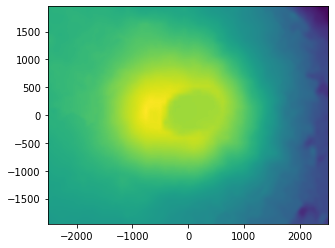

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib inline
fig = plt.figure()
plt.imshow(topo_volcano.topo, 
           extent = (topo_volcano.xmin, topo_volcano.xmax, topo_volcano.ymin, topo_volcano.ymax), 
           origin='lower')

The origin corresponds to geographic coordinates 

In [3]:
print(topo_volcano.lat_center)
print(topo_volcano.lon_center)

-21.244631000000002
55.714066


Save the topographu file in cartersian coordinates for specfem mesh

In [4]:
topo_volcano.save_topo_file('topo_piton_cartesian.xyz')

Convert cmt file into cartesian coordinates 

In [5]:
from PySpecfem.helper.event_helper import *
ev = EventGeo()
ev.import_cmt_file(in_file="CMT_event_0001.txt",   # file with cmt in geographic coordinates 
                   lat = topo_volcano.lat_center,  # reference latitude for topography  
                   lon = topo_volcano.lon_center)  # reference longitude for topography


Save it in new file

In [6]:
ev.convert2cartesian()
ev.save_cmt_cartesian("CMT_event_0001_cart.txt")

Same for stations 

In [7]:
from PySpecfem.helper.station_helper import *
sta = StationGeo()
sta.import_geogr_file(in_file = "station_piton_geogr.txt", 
                      lat = topo_volcano.lat_center, # reference latitude for topography  
                      lon = topo_volcano.lon_center) # reference longitude for topography

In [8]:
sta.convert2cartesian()
sta.save_station_file("station_piton_cart.txt")

## 2. Setup

In [9]:
from PySpecfem.SpecfemProject import *
spe = SpecfemProject()

In [10]:
domain = [-1800., 1800., -1700., 1700., -1500., 2000.]

In [11]:
element_size = [100., 100., 100.]

In [12]:
spe.setup_domain(coords_system = "cartesian",
                 extent = domain,
                 size_elem = element_size,
                 use_sponge = 1,                          # use sponge absorbing layers
                 absorbing_sponge = [300.,300.,300.,0.01], # absorbing layer (~3 elements)
                 topo_file={'xyz':'topo_piton_cartesian.xyz'})    # add topography file in cartesian coordinates

In [13]:
spe.setup_model(model_type = "default",
                number_of_material = 1,
                material_params = [[1, 2340, 3780, 2100, 9999, 0]],
                number_of_domain = 1,
                domain_info = [[1, domain[0], domain[1], domain[2], domain[3], domain[4], domain[5]]])

using mannual material setup.


In [14]:
spe.setup_station(station_type = "sta_file",               # use stations from file 
                  station_file = "station_piton_cart.txt") # station file we've just created 

using station file station setup.


In [15]:
spe.setup_source(source_type= "cmt_file",               
                 cmt_file = "CMT_event_0001_cart.txt",   
                 ricker_f0 = 7.,                         # dominant frequency of the source (try 10)
                 t_shift = -0.1)

In [16]:
spe.setup_path(specfem_directory="/shared/cheese/specfem3d/specfem_fwi")

In [17]:
spe.setup_script(script_type = "pbs")

choose the element size at topography

In [18]:
element_size = [50., 50., 65.]

Define a domain with a doubling brick (mesh refinement)

In [19]:
spe.setup_domain(coords_system = "cartesian",
                 extent = domain,
                 size_elem = element_size,
                 depth_of_doubling = [1600], # at this level, the element size is multiplied by 2
                 use_sponge = 1,                          # use sponge absorbing layers
                 absorbing_sponge = [300.,300.,300.,0.01], # absorbing layer (~3 elements)
                 topo_file={'xyz':'topo_piton_cartesian.xyz'})    # add topography file in cartesian coordinates

To make sure that stations will be at the free surface, we use 'use_elevation_station' flag

In [20]:
spe.setup_specfem_config(number_of_mpi_domain = 8,
                         time_length = 1.,
                         time_step = 0.00025,     # sampling for simulation constrained by CFL
                         time_step_data = 0.005,  # seismogram sampling
                         hdf5_enabled = 0,
                         use_elevation_station = 1, # stations and source are relative to topograpy
                         use_gpu = 0)

Save configuration

In [21]:
spe.write_setup_file()

### Check the configured model

The cell below outputs setup_vis.vtmb which may be open by Paraview etc.

In [31]:
from PySpecfem.vis_project import SpecToVista

# initialize visualization object
# ndiv_* is the number of division for visualization purpose
vspe = SpecToVista(spe, ndiv_x=10, ndiv_y=10, ndiv_z=50)

# change source size
vspe.rad_rec = 30
vspe.rad_src = 100

# write visualization file
# with write_vtk=False, pyspecfem will try to open a interactive plot on jupyter
# with docker image, user need to configure for use X11 DISPLAY environment
vspe.plot_3d(station_on_surface=True,write_vtk=True)

ox :  -2519.5818866933514  oy :  -1952.3075925503433
dx :  10.368089899576717  dy :  11.123758293648734
nx :  487  ny :  352
n :  171427


### Copy files in remote cluster 

In [26]:
!scp setup_file.in sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/Piton/.


lost connection


In [27]:
!scp station_piton_cart.txt sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/Piton/.


lost connection


In [28]:
!scp topo_piton_cartesian.xyz sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/Piton/.


lost connection


In [29]:
!scp CMT_event_0001_cart.txt sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/Piton/.


lost connection


## 3. Launch specfem in remote cluster

In [30]:
qsub -q smp run_generate_databases_2.pbs 
qstat

SyntaxError: invalid syntax (1903040972.py, line 1)

Change the walltion in run_FWI_forward.pbs file form 00:30:00 to 00:45:00

The simulation is about 35 minutes, in the meantime download the mesh for visualization (part 5)

## Download sismograms from remote cluster

In [ ]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/Piton/DATA_DIR/EV_1/Gather.bin .

Gather.bin                                    100%   16KB  16.4KB/s   00:00    


In [ ]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/Piton/DATA_DIR/EV_1/Gather.bin.hdr .

Gather.bin.hdr                                100%  145     0.1KB/s   00:00    


In [ ]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/Piton/DATA_DIR/EV_1/STATIONS_FILTERED .

STATIONS_FILTERED                             100%  658     0.6KB/s   00:00    


In [ ]:
from PySpecfem.helper.sismograms import SismoGather
# class for managing seismograms
synth0 =  SismoGather(verb=False)
# directory where seismograms are downloaded
directory_with_files= "./"
# name of binary file with computed seismograms
file_with_sythetics = "Gather.bin"
# metadata associated with seismograms
metadata_file = "Gather.bin.hdr"
# read computed seismograms
synth0.read_inputs(directory_with_files, file_with_sythetics, metadata_file)


In [ ]:
synth0.display_station()

  Network Station       latitude      longitude     elevation
0      YA     FJS   0.168303E+04   0.853730E+03  0.000000E+00
1      YA     RVL  -0.125353E+04  -0.140632E+04  0.000000E+00
2      YA     SNE   0.615256E+03   0.397520E+03  0.000000E+00
3      YA    UV05  -0.441508E+03   0.352501E+01  0.000000E+00
4      YA    UV11   0.537390E+03  -0.504522E+03  0.000000E+00
5      YA    UV12  -0.119789E+04   0.110237E+04  0.000000E+00
6      YA    UV15  -0.521803E+02  -0.535611E+03  0.000000E+00


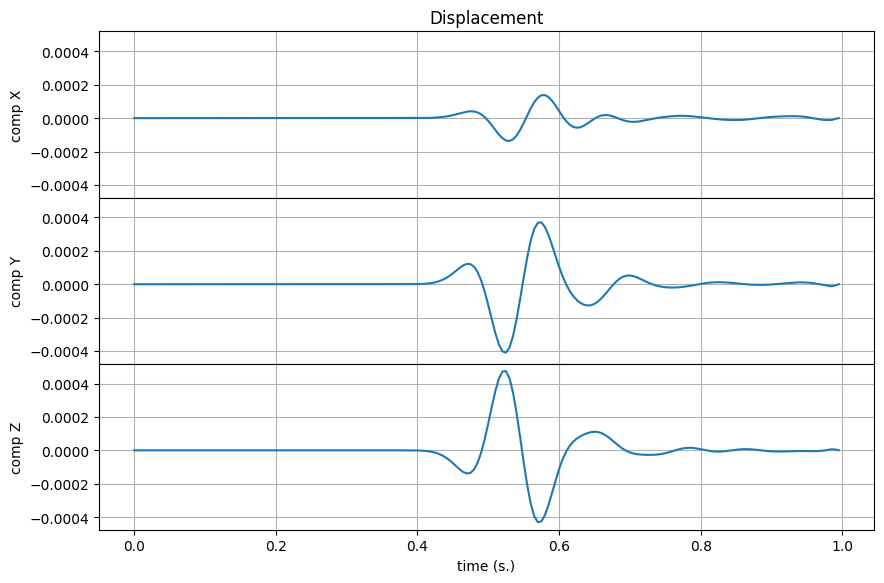

In [ ]:
%matplotlib inline
%matplotlib inline
synth0.display_sismogram(irec=6)

## 5. Download mesh 

In [ ]:
!scp sca50903@training.hlrs.de:/shared/training/ws/sca50903-specfem3d_scratch/Piton/DATABASES_MPI/proc000000_mesh.vtk .

proc000000_mesh.vtk                           100%   14MB 194.0KB/s   01:16    


open it with paraview

 find the file in remote cluster ??/DATA_DIR/EV_1/STATIONS.vtk, download it and load in paraview with the mesh (use "point gaussian" to see stations)

It is also possible to do some snapshots, but it will require to download few hundreds Mb thus it is not recommended to do during this training session. 